In [1]:
from arcgis.gis import GIS

In [2]:
gis = GIS('https://python.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
print("Successfully connected to {0}".format(gis.properties.name))

Successfully connected to Python Playground


<Item title:"Human Modification for North America" type:Imagery Layer owner:arcgis_python>
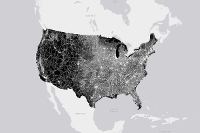

In [3]:
hmna_item = gis.content.search('title:Human Modification for North America', 'Imagery Layer')[0]
hmna_item

<Item title:"National Elevation Dataset (NED)" type:Imagery Layer owner:arcgis_python>
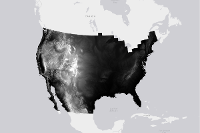

In [4]:
elev_item = gis.content.search('title:National Elevation Dataset (NED)', 'Imagery Layer')[0]
elev_item

<Item title:"USA States (Generalized)" type:Feature Layer Collection owner:esri_livingatlas>
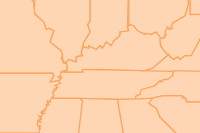

In [5]:
states_item = gis.content.search("id:99fd67933e754a1181cc755146be21ca", 'Feature Layer', outside_org=True)[0]
states_item

We choose the State of Washington as our study area for this example.

In [6]:
states_lyr = states_item.layers[0]

In [7]:
study_area_query = states_lyr.query("STATE_NAME='Washington'", return_geometry=True)

In [8]:
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

In [9]:
from arcgis.geocoding import geocode
# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_gcd = geocode(address='State of Washington, USA', out_sr=hmna_item.layers[0].extent['spatialReference'])
# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_gcd[0]['extent']
study_area_extent

{'xmax': -1451059.3770040546,
 'xmin': -2009182.5321227335,
 'ymax': 1482366.818700374,
 'ymin': 736262.260048952}

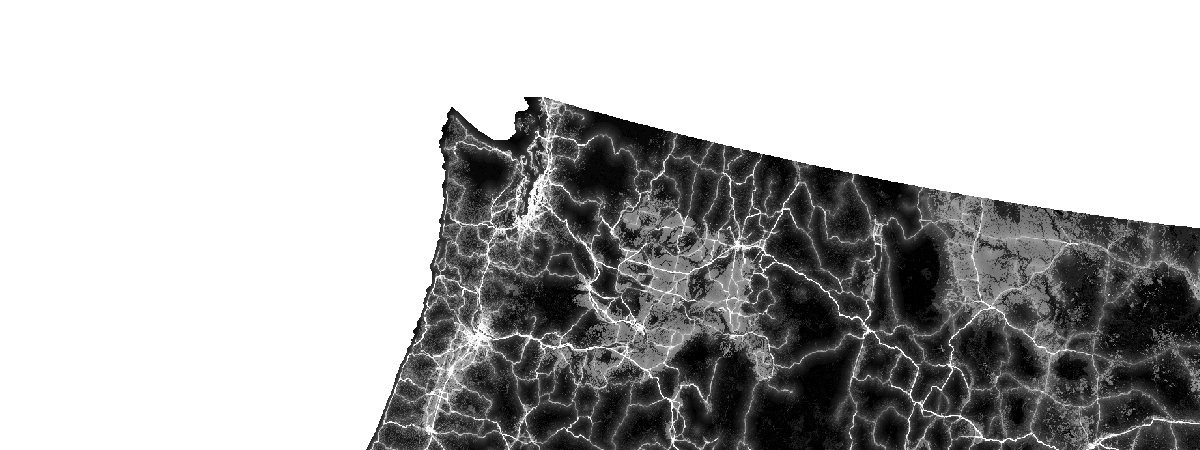

In [10]:
# Get a reference to the imagery layer from the portal item
hmna_lyr = hmna_item.layers[0]
# Set the layer extent to geographic extent of study area and display the data.
hmna_lyr.extent = study_area_extent
hmna_lyr

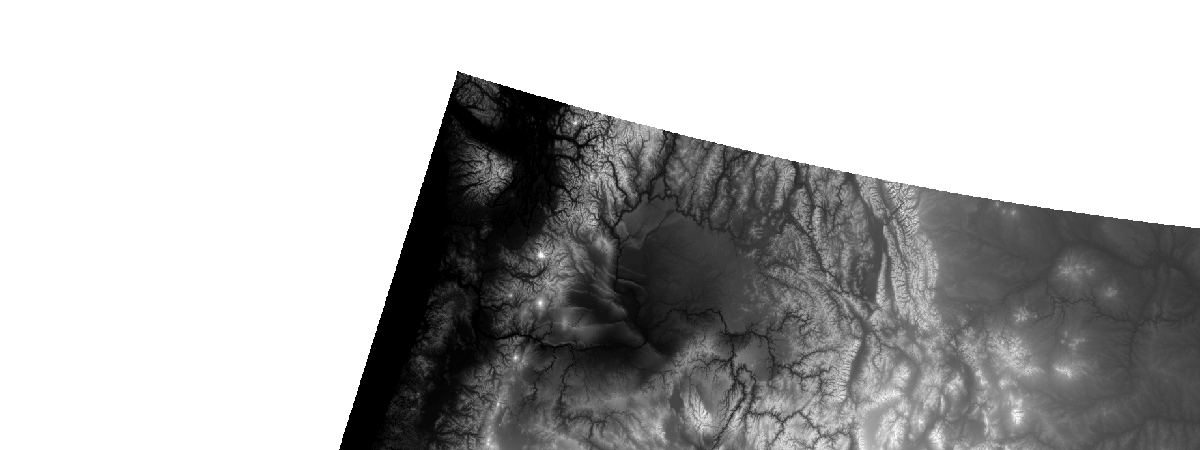

In [11]:
elev_lyr = elev_item.layers[0]
# Set the layer extent to the geographic extent of study area and display the data.
elev_lyr.extent = study_area_extent
elev_lyr

In [12]:
from arcgis.raster.functions import *

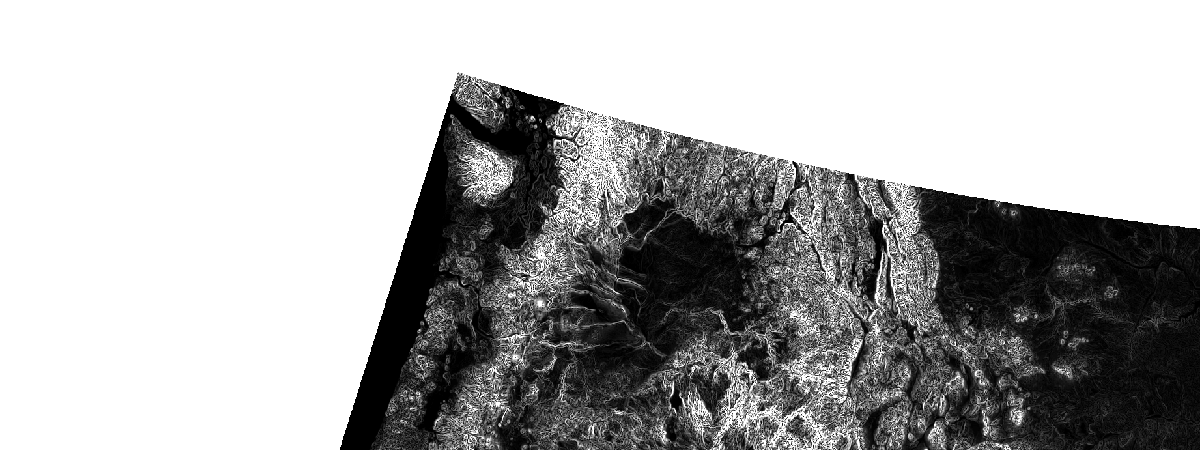

In [13]:
slope_lyr = slope(dem=elev_lyr, slope_type='DEGREE', z_factor=1)
slope_lyr.extent = study_area_extent
# Use the stretch function to enhance the display of the slope layer.
stretch(raster=slope_lyr, stretch_type='StdDev', dra='true')

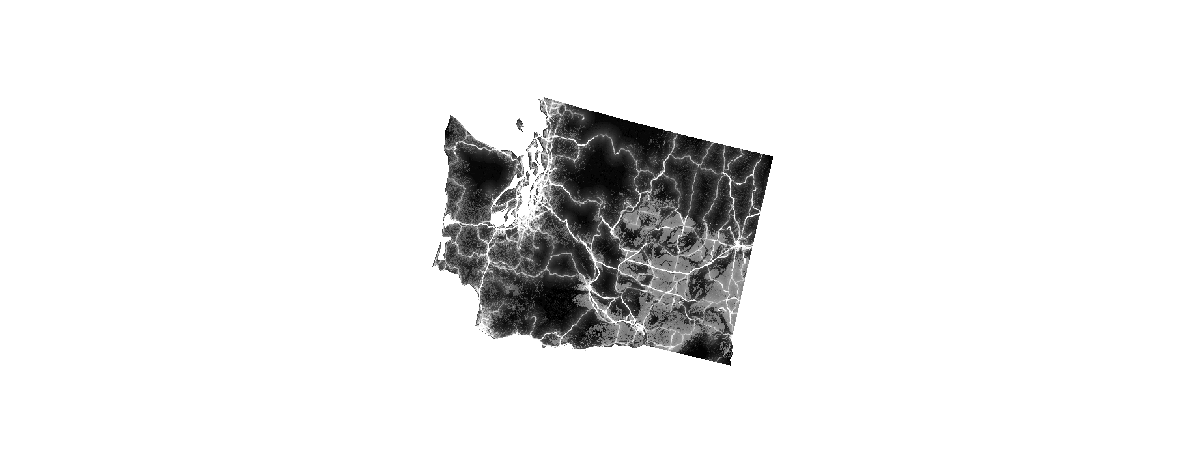

In [14]:
hmna_study_area = clip(raster=hmna_lyr, geometry=study_area_geom)
hmna_study_area

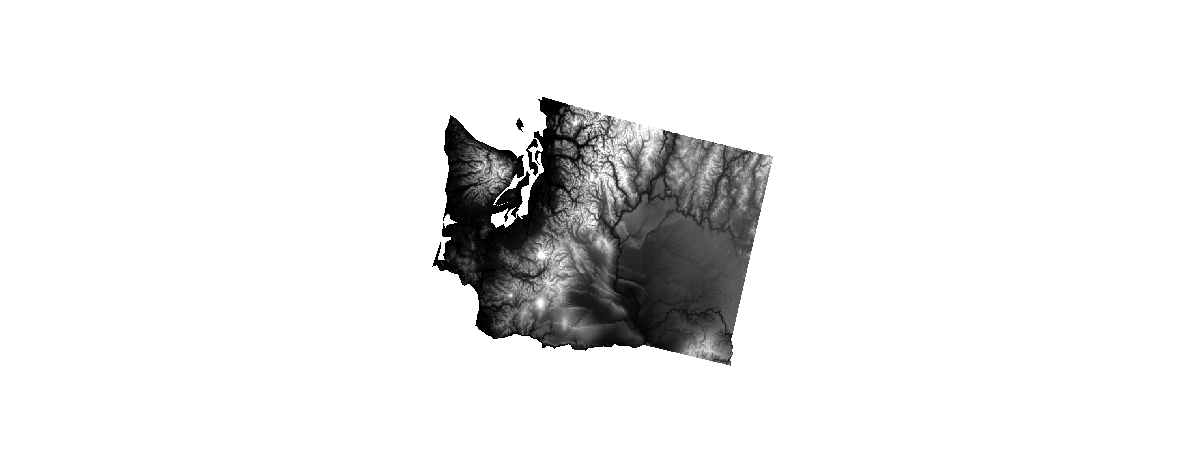

In [15]:
elev_study_area = clip(raster=elev_lyr, geometry=study_area_geom)
elev_study_area

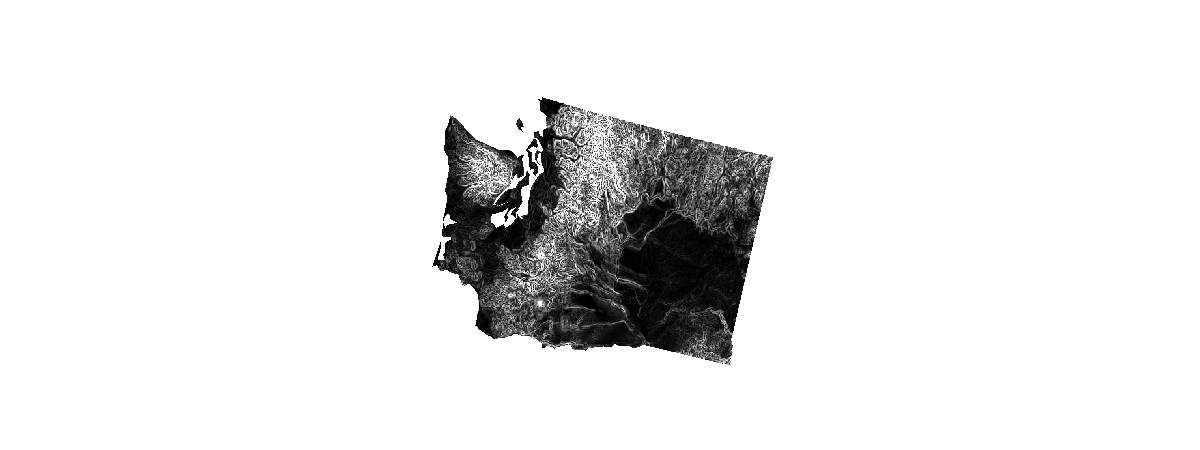

In [16]:
slope_study_area = clip(raster=slope_lyr, geometry=study_area_geom)
# Apply the Stretch function to enhance the display of the slope_clipped layer.
stretch(raster=slope_study_area, stretch_type='StdDev', dra='true')

In [17]:
clrmap=  [[1, 230, 0, 0], [2, 242, 85, 0], [3, 250, 142, 0], [4, 255, 195, 0], [5, 255, 255, 0], [6, 197, 219, 0],  
          [7, 139, 181, 0], [8, 86, 148, 0], [9, 38, 115, 0]]

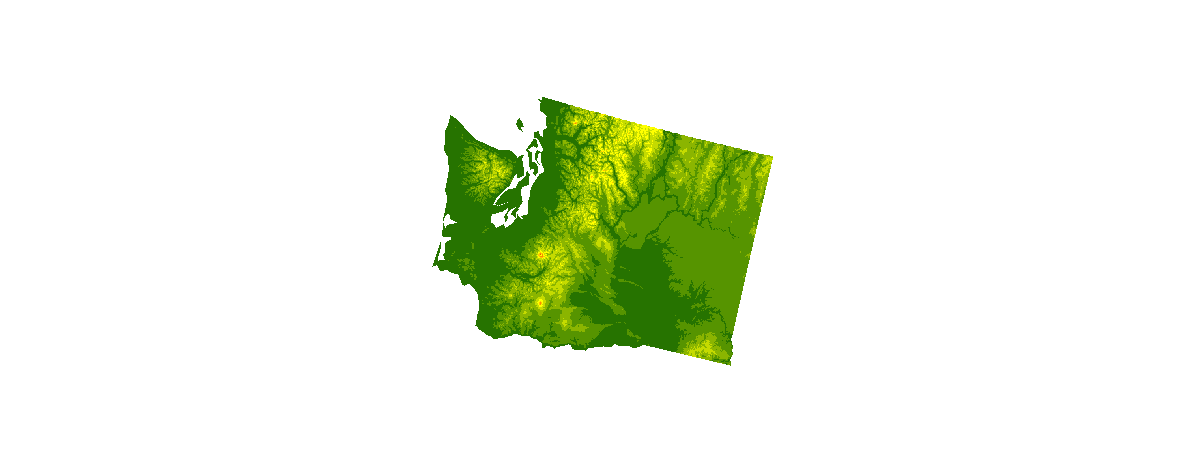

In [18]:
elev_normalized = remap(elev_study_area,
                       input_ranges=[0,490, 490,980, 980,1470, 1470,1960, 1960,2450, 
                                     2450,2940, 2940,3430, 3430,3700, 3920,4100],
                       output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(elev_normalized, colormap=clrmap)

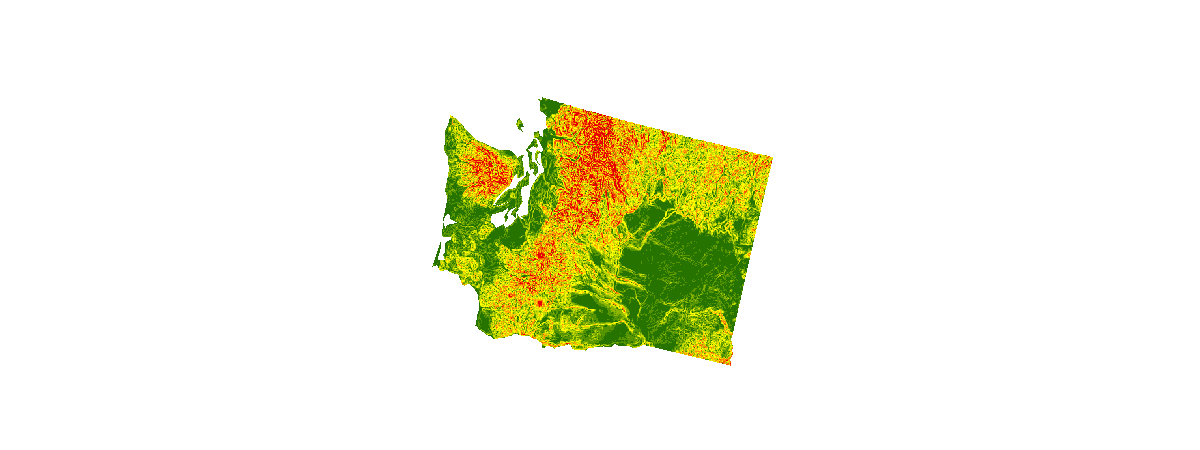

In [19]:
# Reclassify the slope data
slope_normalized = remap(raster=slope_study_area, 
                        input_ranges=[0,1, 1,2, 2,3, 3,5, 5,7, 7,9, 9,12, 12,15, 15,100],
                        output_values=[9,8,7,6,5,4,3,2,1],  astype='U8') 

# Display a color-mapped image of the reclassified slope data
colormap(slope_normalized, colormap=clrmap)

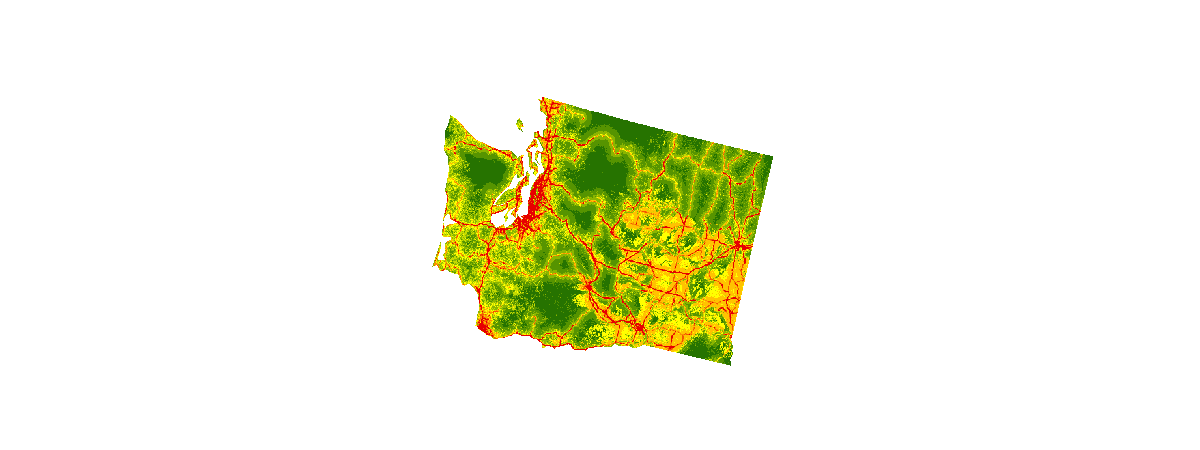

In [20]:
# Reclassify the Human Modified Index data
hmna_normalized = remap(raster=hmna_study_area,
                  input_ranges=[0.0,0.1, 0.1,0.2, 0.2,0.3, 0.3,0.4, 0.4,0.5,
                                0.5,0.6, 0.6,0.7, 0.7,0.8, 0.8,1.1],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')

# Display a color-mapped image of the reclassified HMI data
colormap(hmna_normalized, colormap=clrmap)

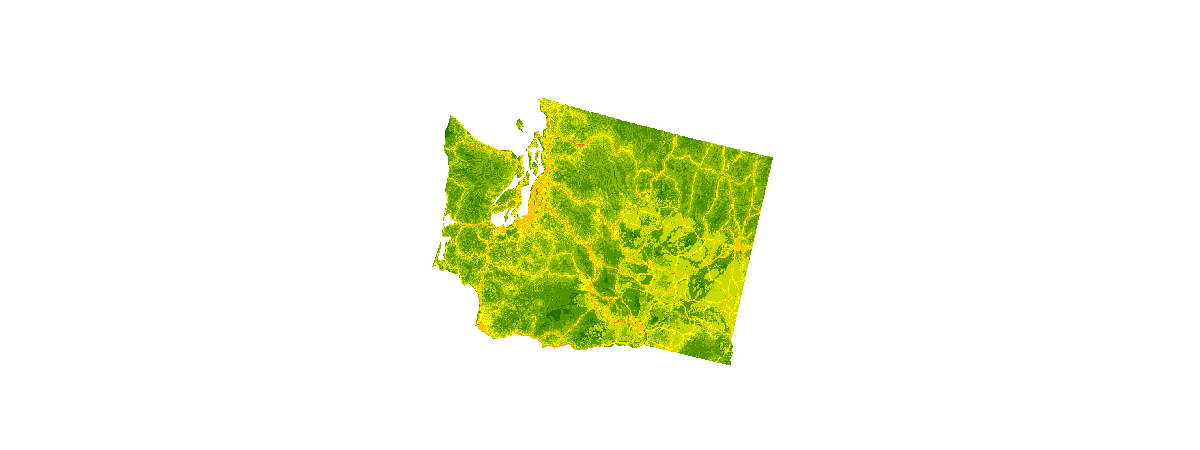

In [21]:
result_weighted_overlay = colormap(hmna_normalized * 0.6 + 
                                    slope_normalized * 0.25 + 
                                    elev_normalized * 0.15,
                                    colormap=clrmap)
result_weighted_overlay

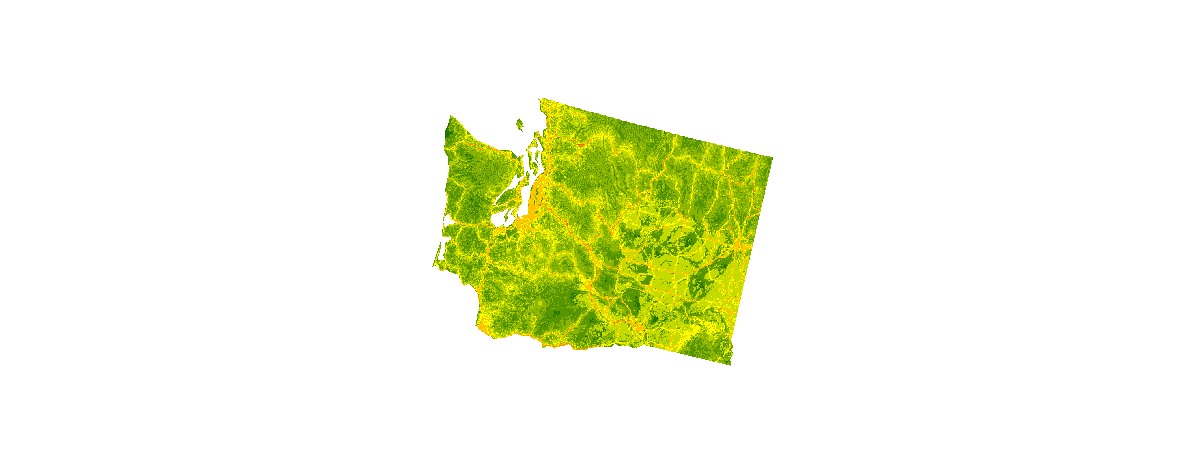

In [22]:
result_weighted_overlay_one_op = colormap(
        # Human modified index layer
        0.60 * remap(clip(raster=hmna_lyr, geometry=study_area_geom),
                     input_ranges=[0.0,0.1, 0.1,0.2, 0.2,0.3, 0.3,0.4, 0.4,0.5,
                                   0.5,0.6, 0.6,0.7, 0.7,0.8, 0.8,1.1],
                     output_values=[9,8,7,6,5,4,3,2,1])
        + 
        # Slope layer
        0.25 * remap(clip(raster=slope_lyr, geometry=study_area_geom), 
                     input_ranges=[0,1, 1,2, 2,3, 3,5, 5,7, 7,9, 9,12, 12,15, 
                                   15,100],
                     output_values=[9,8,7,6,5,4,3,2,1]) 
        +
        # Elevation layer
        0.15 * remap(clip(raster=elev_lyr, geometry=study_area_geom), 
                    input_ranges=[-90,250, 250,500, 500,750, 750,1000, 1000,1500, 
                                  1500,2000, 2000,2500, 2500,3000, 3000,5000],
                    output_values=[9,8,7,6,5,4,3,2,1]),
    colormap=clrmap,  astype='U8'
)
result_weighted_overlay_one_op

In [23]:
import arcgis
arcgis.raster.analytics.is_supported(gis)

True

In [24]:
search_persistent_result = gis.content.search(query="title:NaturalAndAccessible_WashingtonState")[0]
search_persistent_result

<Item title:"NaturalAndAccessible_WashingtonState" type:Imagery Layer owner:arcgis_python>

In [25]:
# Create a map to display the persistent analysis result in a map
map1 = gis.map('State of Washington, USA')
map1.add_layer(search_persistent_result)
# Create a map to display the dynamic analysis result in another map.
map2 = gis.map('State of Washington, USA')
map2.add_layer(result_weighted_overlay)

In [26]:
map1

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [27]:
map2

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [28]:
from ipywidgets import *
map1.layout = Layout(flex='1 1', padding = '10px')
map2.layout = Layout(flex='1 1', padding = '10px')
box = HBox([map1, map2])
box

HBox(children=(MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='10px')), MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='10px'))))